# Rotational Scales
Inspired by [clock diagrams](https://www.youtube.com/watch?v=oGeBem72R3Y), I want to generalize that idea into treating scales (and chords) as *rotations* around a circle. This means, for example, that a chromatic scale can be divided into twelve rotational steps, or `2*PI/12`.

In [1]:
import numpy as np
chromatic_step = 2*np.pi/12.0
chromatic_scale = np.zeros((12,))
for i in range(12):
    chromatic_scale[i] = i * chromatic_step
print(chromatic_scale)

[0.         0.52359878 1.04719755 1.57079633 2.0943951  2.61799388
 3.14159265 3.66519143 4.1887902  4.71238898 5.23598776 5.75958653]


If we want to convert to MIDI notes, we need to first invert our process (`*12/2*PI`), then add our base note

In [2]:
c_chromatic_scale = (chromatic_scale * 12.0 / (2*np.pi))+60
print(c_chromatic_scale)

[60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.]


In [51]:
def to_angles(notes:np.array, base=None):
    """
    Convert a set of notes into deflection angles 
    relative to a base note (the first note of the sequence, by default)
    """
    if (base is None):
        base = notes[0]
    return (notes - base) * 2*np.pi/12.0

def from_angles(angles:np.array, base=60):
    """
    Convert a set of angles into MIDI notes (fractional steps allowed), moving upwards
    from a base note (middle C by default)
    """
    return (angles % (2*np.pi)) * 12.0 / (2*np.pi) + base

to_notes = from_angles #for convenience

The interesting features, though, are going to show up when we start doing other types of note groups. For example, your standard major chord, in clock theory, are `047` (0/12, 4/12, and 7/12)

In [4]:
triad = to_angles(np.array([0, 4, 7]), 0)
print(triad)
print(from_angles(triad))

[0.         2.0943951  3.66519143]
[60. 64. 67.]


Now, if we wanted the inversion of that, we can reflect around any axis. In clock theory, if we invert on the 0 axis, then the 4 should become 8 and the 7 should become 5.

In [5]:
def non_normal_reflect(angles, axis):
    distances = angles-axis
    return axis-distances

In [6]:
reflected = non_normal_reflect(triad, 0)
print(from_angles(reflected, 0))

[0. 8. 5.]


What about if we reflected around the 3 position. 0 becomes 6, 2 becomes 4, and 7 becomes 11

In [7]:
reflected = non_normal_reflect(triad, 3*chromatic_step)
print(from_angles(reflected, 0))

[ 6.  2. 11.]


Cool, so we can have some fun music theory games. Transpositions are easy (just rotate). Inversions/reflections allow us to find harmonic sense. We can also play with these on a graph.

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
def clock_diagram(angles):
    normalized = angles % (2*np.pi)
    sp = plt.subplot(1, 1, 1, projection='polar')
    sp.set_theta_zero_location('N')
    sp.set_theta_direction(-1)
    sp.set_xticks(np.linspace(0,2*np.pi,13)[0:-1])
    sp.set_yticks([])
    plt.polar(normalized, np.full(normalized.shape, 1), "ro")

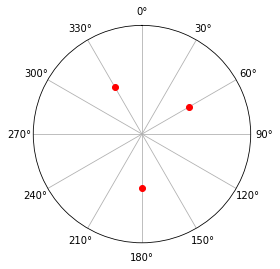

In [45]:
clock_diagram(reflected)

Now, the real fun is in building alternate, microtonal tuning systems. We *don't* need to limit ourselves to the traditional 12 semitones. Let's start with a 13 semitone chromatic scale.

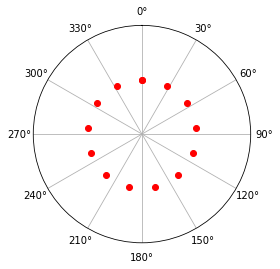

In [46]:
tridek_scale = np.linspace(0,2*np.pi,14)
clock_diagram(tridek_scale)

In [68]:
tridek_midi = from_angles(tridek_scale, 60)
tridek_midi[-1] += 12 #add an octave
print(tridek_midi)

[60.         60.92307692 61.84615385 62.76923077 63.69230769 64.61538462
 65.53846154 66.46153846 67.38461538 68.30769231 69.23076923 70.15384615
 71.07692308 72.        ]


While MIDI itself doesn't usually support floating point values, many pieces of synthesizer software can generate tones using these, including my own [Shadow Music](https://github.com/RemyPorter/ShadowMusic/) synth library. But here's a midi-note-to-frequency convertor

In [25]:
def midi_to_hz(midi, concert_a=440, base=12):
  """
  Take a midi note number (floating points accepted!) and convert it to a frequency

  concert_a is the concert a frequency for your tuning, and base could be used to translate
  alternate tunings with differing numbers of semitones per octave
  """
  a = 69 #the "a above middle C"
  return np.power(2, ((midi-a)/base))*concert_a

In [32]:
midi_to_hz(tridek_midi)

array([261.6255653 , 275.95377102, 291.06667635, 307.00725621,
       323.82083908, 341.55523592, 360.26087609, 379.99095079,
       400.80156426, 422.75189338, 445.90435591, 470.32478797,
       496.08263128, 523.2511306 ])

Okay, but the chromatic scale isn't interesting. Let's extract a pattern, say a sequence of half-step/step/half-step/step?

In [37]:
pattern = [0,1,3,4,6,7,9,10,12,13]
tridek_major = tridek_scale[pattern]
tridek_major_midi = from_angles(tridek_major, 60)
tridek_major_midi[-1] += 12
midi_to_hz(tridek_major_midi)

array([261.6255653 , 275.95377102, 307.00725621, 323.82083908,
       360.26087609, 379.99095079, 422.75189338, 445.90435591,
       496.08263128, 523.2511306 ])

Now, we can extract a chord from here.

In [40]:
m = [0,4,7]
tridek_chrd = tridek_major[m]
tridek_chrd_midi = from_angles(tridek_chrd, 60)
midi_to_hz(tridek_chrd_midi)

array([261.6255653 , 360.26087609, 445.90435591])

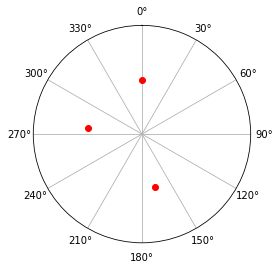

In [47]:
clock_diagram(tridek_chrd)

Or reflect it to create new chords?

array([261.6255653 , 379.99095079, 307.00725621])

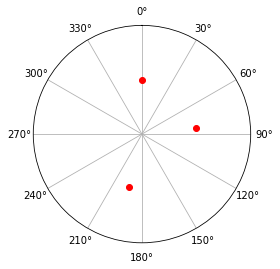

In [48]:
tridek_inv = non_normal_reflect(tridek_chrd, 0)
clock_diagram(tridek_inv)
midi_to_hz(from_angles(tridek_inv, 60))

array([496.08263128, 360.26087609, 291.06667635])

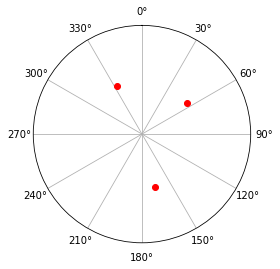

In [50]:
tridek_offset_inv = non_normal_reflect(tridek_chrd, tridek_chrd[1])
clock_diagram(tridek_offset_inv)
midi_to_hz(from_angles(tridek_offset_inv, 60))

The Tridek scale demonstrates one way to use the rotational approach (a generalization of the Clock Diagram) to generate interesting results in music theory. I think there's a lot more room for experimentation on this. There's certainly no reason why our "scale" needs to be build on equally spaced intervals, for example. So, we could do something like:

array([261.6255653 , 267.3544192 , 273.20871866, 291.5520615 ,
       311.12698372, 346.71578592, 412.3168795 ])

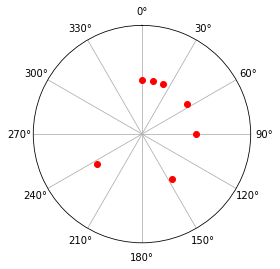

In [56]:
base_step = 2*np.pi/32.0 #divide the circle into 32 steps
escalating_scale = np.array([0,1,2,5,8,13,21]) * base_step #spread them out fibinocciwise
clock_diagram(escalating_scale)
midi_to_hz(from_angles(escalating_scale, 60))

Now, in this case, there's still a fundamental chromaticism (a 32 step chromatic scale) and we're simply choosing notes by using the fibonnaci sequence to sample outside of that. In a way, that's going to be somewhat fundamental: music needs intervals of *some kind*, and while rotation serves as a continious function, we need some mechanism for spacing out our selected notes.

But that *doesn't* have to be how we do it. Instead of thinking in terms of intervals, we could think in terms of transforms.

[60.  62.4 64.8 67.2 69.6 72. ]


array([261.6255653 , 300.52885649, 345.21700307, 396.55020355,
       455.51656649, 523.2511306 ])

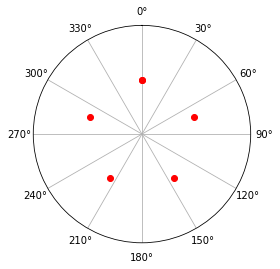

In [67]:
reflections = np.linspace(0,np.pi,6)
base_note = [0]
reflected_scale = np.array([non_normal_reflect(base_note,r)[0] for r in reflections])
clock_diagram(reflected_scale)
reflected_midi = to_notes(reflected_scale, 60)
reflected_midi[-1] += 12
print(reflected_midi)
midi_to_hz(reflected_midi)

In this case, since we took 6 lines of reflection, we get something very similar- but not _exactly_ like a pentatonic scale. It's a pentatonic whole tone scale. And there's no reason why we have to limit ourselves like this. We could start with a single deflection, and then stack reflections atop each other.

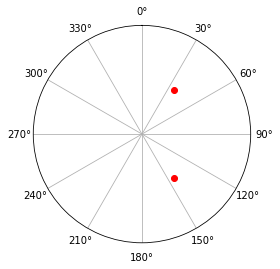

In [76]:
base_note = np.array([np.pi/5.0])
first_reflection = np.concatenate([non_normal_reflect(base_note, np.pi/2.0), base_note])
clock_diagram(first_reflection)

[67.2 70.8 64.8 61.2]


array([396.55020355, 488.21056771, 345.21700307, 280.40333801])

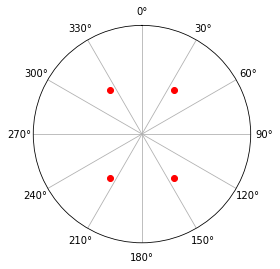

In [81]:
second_reflection = np.concatenate([non_normal_reflect(first_reflection, np.pi), first_reflection])
clock_diagram(second_reflection)
print(to_notes(second_reflection, 60))
midi_to_hz(to_notes(second_reflection, 60))

It's also important to note that we can easily take an arrangement like this and transpose it by simply adding a rotation.

[69.2 60.8 66.8 63.2]


array([445.11255373, 273.99891692, 387.49298438, 314.74210514])

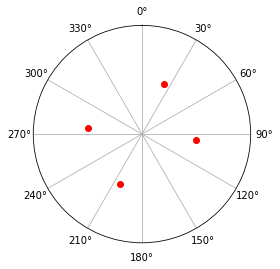

In [83]:
rotated_reflection = second_reflection + np.pi/3
clock_diagram(rotated_reflection)
print(to_notes(rotated_reflection, 60))
midi_to_hz(to_notes(rotated_reflection, 60))